# Biologia Systemów - Spektrometria Mas

Celem projektu było stworzenie modelu klasyfikacyjnego dla funkcji Offset, określającą zaokrągloną do liczby całkowitej różnicę między masą najwyższego wierzchołka $M_{mostAbundant}$ a masą monoizotopową $M_{mono}$.

$M_{mono} = M_{mostAbundant} - Offset (M_{mostAbundant}, r)$

Pomysł (_proof-of-concept_):

- Stworzenie modelu klasyfikacyjnego z cechami: m_mostAb (znormalizowane min-max od 0 do 1) + wszystkie możliwe 21 stosunki wierzchołków $r$

- Etykietą dla modelu jest offset (liczba całkowita - tu: od 0 do 13), czyli zaokrąglona różnica między najwyższym wierzchołkiem a masą monoizotopową

- Ewaluacja modelu za pomocą różnych metryk uzyskanych z predykcji na zbiorze testowym

- Analiza istotności stosunków wierzchołków $r$ za pomocą wartości SHAP oraz sprawdzenie czy i jak wartość $M_{mostAb}$ wpływa na tę istotność

- Wnioski z powyższej analizy

W pracy wykorzystano wielowymiarowy model regresji logistycznej (ang. _multinomial logistic regression_), ze względu na to że jest to prosty model - ma duży potencjał na to, że będzie się generalizował do prawdziwych danych, które często są zaszumione.


In [58]:
import pandas as pd
import numpy as np
import random
from plotnine import *
random.seed(1234)


In [59]:
df = pd.read_csv("binned_extended.csv", index_col=0)
df.describe()

,C,H,N,O,S,P,mode,mono,-3,-2,-1,0,1,2,3
count,3.039431e+06,3.039431e+06,3.039431e+06,3.039431e+06,3039431.0,3.039431e+06,3.039431e+06,3.039431e+06,3.027044e+06,3.036323e+06,3.039074e+06,3.039431e+06,3.039431e+06,3.039431e+06,3.039431e+06
mean,7.020212e+02,8.840267e+02,2.700081e+02,4.330135e+02,0.0,7.200219e+01,2.226232e+04,2.225233e+04,7.384861e-02,9.564010e-02,1.112509e-01,1.167775e-01,1.117173e-01,9.862795e-02,8.119112e-02
std,1.479108e+02,1.855040e+02,7.161302e+01,9.367024e+01,0.0,1.509607e+01,4.689549e+03,4.687308e+03,8.211767e-03,8.711235e-03,1.470728e-02,1.811610e-02,1.532720e-02,9.999007e-03,6.312174e-03
min,4.500000e+01,6.200000e+01,1.000000e+01,2.600000e+01,0.0,5.000000e+00,1.463242e+03,1.463242e+03,2.147227e-02,5.383129e-02,9.399626e-02,9.978413e-02,9.447752e-02,8.363220e-02,2.729619e-02
25%,6.180000e+02,7.780000e+02,2.220000e+02,3.790000e+02,0.0,6.300000e+01,1.958635e+04,1.957733e+04,6.878778e-02,8.974333e-02,1.016859e-01,1.053961e-01,1.016782e-01,9.209699e-02,7.624849e-02
50%,7.380000e+02,9.300000e+02,2.730000e+02,4.520000e+02,0.0,7.600000e+01,2.340420e+04,2.339381e+04,7.446753e-02,9.405709e-02,1.067846e-01,1.107103e-01,1.065811e-01,9.630511e-02,8.075084e-02
75%,8.190000e+02,1.031000e+03,3.220000e+02,5.040000e+02,0.0,8.400000e+01,2.596520e+04,2.595317e+04,7.984812e-02,9.968081e-02,1.157765e-01,1.213906e-01,1.157494e-01,1.025511e-01,8.505093e-02
max,9.000000e+02,1.172000e+03,4.500000e+02,6.310000e+02,0.0,9.000000e+01,2.964577e+04,2.963274e+04,9.011543e-02,1.457939e-01,3.362409e-01,5.349938e-01,3.418495e-01,1.993214e-01,1.066619e-01


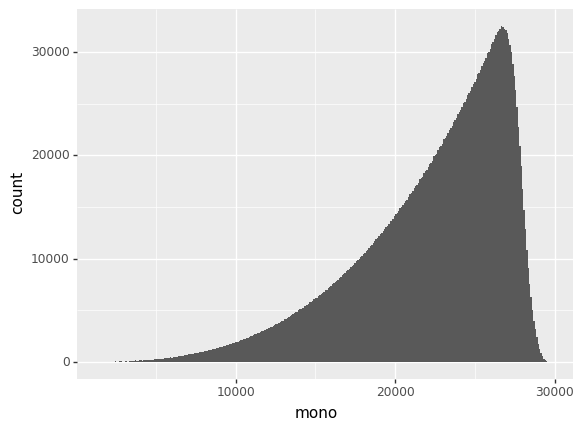

<ggplot: (165550835429)>

In [60]:
ggplot() + geom_histogram(aes(df["mono"]), bins=320)

In [61]:
nrows = df.shape[0]
nsamples = 1e6
from sklearn.utils.random import sample_without_replacement
sample_idx = sample_without_replacement(nrows, nsamples, random_state=1234)

In [62]:
# podzbiór danych
df = df.loc[sample_idx]
df

,C,H,N,O,S,P,mode,mono,-3,-2,-1,0,1,2,3
842761,631,806,215,397,0,65,19767.267599,19758.243521,0.080229,0.102817,0.117153,0.120736,0.113594,0.098618,0.079541
1090827,684,848,300,425,0,70,22239.585285,22229.559882,0.079385,0.099154,0.111761,0.114949,0.108883,0.095757,0.078698
2832614,870,1087,354,539,0,89,27883.551351,27870.517806,0.080824,0.093943,0.101167,0.101672,0.095829,0.085158,0.071582
526213,556,719,179,367,0,58,17577.809910,17569.788306,0.082759,0.108736,0.124817,0.127709,0.118322,0.100365,0.078608
484359,544,677,239,304,0,56,17162.037298,17154.016950,0.088252,0.114379,0.129247,0.129891,0.117829,0.097701,0.074578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140417,397,514,119,261,0,41,12397.998579,12392.984831,0.055020,0.097597,0.134226,0.152016,0.147549,0.125725,0.095967
1182022,673,871,230,428,0,71,21228.507292,21219.483183,0.064451,0.087649,0.105975,0.115695,0.115373,0.106089,0.090656
2640579,868,1065,374,505,0,87,27510.663168,27498.632514,0.065717,0.082655,0.095563,0.102306,0.102128,0.095625,0.084331
2157357,817,1000,383,488,0,83,26563.372960,26551.342956,0.076842,0.092611,0.102666,0.105372,0.101004,0.090749,0.076855


In [63]:
df.replace(np.nan, 0, inplace=True) # NaN traktuję jak 0
df.head()

,C,H,N,O,S,P,mode,mono,-3,-2,-1,0,1,2,3
842761,631,806,215,397,0,65,19767.267599,19758.243521,0.080229,0.102817,0.117153,0.120736,0.113594,0.098618,0.079541
1090827,684,848,300,425,0,70,22239.585285,22229.559882,0.079385,0.099154,0.111761,0.114949,0.108883,0.095757,0.078698
2832614,870,1087,354,539,0,89,27883.551351,27870.517806,0.080824,0.093943,0.101167,0.101672,0.095829,0.085158,0.071582
526213,556,719,179,367,0,58,17577.809910,17569.788306,0.082759,0.108736,0.124817,0.127709,0.118322,0.100365,0.078608
484359,544,677,239,304,0,56,17162.037298,17154.016950,0.088252,0.114379,0.129247,0.129891,0.117829,0.097701,0.074578


In [64]:
def calc_int_offset(x, y):
    return int(x - y)

calc_offset = np.vectorize(calc_int_offset)
df["offset"] = calc_offset(df["mode"], df["mono"])

In [65]:
df.head()

,C,H,N,O,S,P,mode,mono,-3,-2,-1,0,1,2,3,offset
842761,631,806,215,397,0,65,19767.267599,19758.243521,0.080229,0.102817,0.117153,0.120736,0.113594,0.098618,0.079541,9
1090827,684,848,300,425,0,70,22239.585285,22229.559882,0.079385,0.099154,0.111761,0.114949,0.108883,0.095757,0.078698,10
2832614,870,1087,354,539,0,89,27883.551351,27870.517806,0.080824,0.093943,0.101167,0.101672,0.095829,0.085158,0.071582,13
526213,556,719,179,367,0,58,17577.809910,17569.788306,0.082759,0.108736,0.124817,0.127709,0.118322,0.100365,0.078608,8
484359,544,677,239,304,0,56,17162.037298,17154.016950,0.088252,0.114379,0.129247,0.129891,0.117829,0.097701,0.074578,8


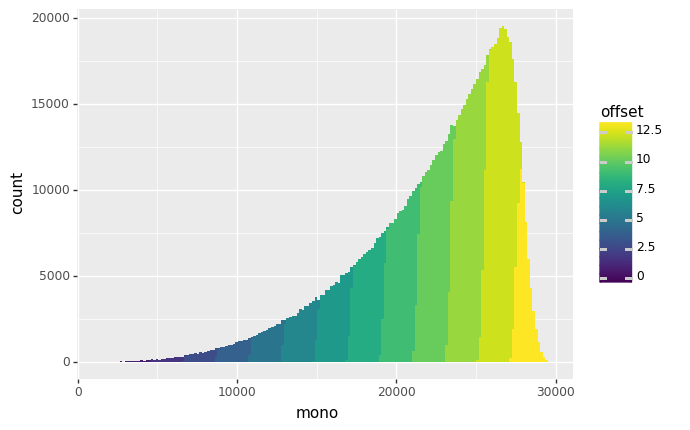

<ggplot: (165465768319)>

In [66]:
ggplot(df, aes(x="mono", group="offset", fill="offset")) + geom_histogram(bins=176)
# fill i color nie działają

In [67]:
import itertools
colnames = ["-3", "-2", "-1", "0", "1", "2", "3"]
features = []
column_pairs = list(itertools.combinations(colnames, 2))
for pair in column_pairs:
    col_name = pair[0] + '_' + pair[1] + '_ratio'
    features.append(col_name)
    df[col_name] = df[pair[0]] / df[pair[1]]

In [68]:
df.head()

,C,H,N,O,S,P,mode,mono,-3,-2,...,-1_0_ratio,-1_1_ratio,-1_2_ratio,-1_3_ratio,0_1_ratio,0_2_ratio,0_3_ratio,1_2_ratio,1_3_ratio,2_3_ratio
842761,631,806,215,397,0,65,19767.267599,19758.243521,0.080229,0.102817,...,0.970320,1.031323,1.187941,1.472854,1.062869,1.224277,1.517906,1.151861,1.428121,1.239838
1090827,684,848,300,425,0,70,22239.585285,22229.559882,0.079385,0.099154,...,0.972271,1.026435,1.167140,1.420121,1.055709,1.200427,1.460623,1.137081,1.383547,1.216753
2832614,870,1087,354,539,0,89,27883.551351,27870.517806,0.080824,0.093943,...,0.995028,1.055698,1.187990,1.413306,1.060973,1.193926,1.420368,1.125312,1.338741,1.189662
526213,556,719,179,367,0,58,17577.809910,17569.788306,0.082759,0.108736,...,0.977352,1.054889,1.243629,1.587837,1.079334,1.272448,1.624632,1.178920,1.505217,1.276777
484359,544,677,239,304,0,56,17162.037298,17154.016950,0.088252,0.114379,...,0.995041,1.096900,1.322882,1.733033,1.102366,1.329475,1.741670,1.206019,1.579937,1.310043


In [94]:
features.append("mode") # nazwy cech
# wykorzystanie informacji o mode powoduje że staje się on najistotniejszą cechą w modelu
# można ominąć powyższą linijkę i sprawdzić co wyjdzie
features

['-3_-2_ratio',
 '-3_-1_ratio',
 '-3_0_ratio',
 '-3_1_ratio',
 '-3_2_ratio',
 '-3_3_ratio',
 '-2_-1_ratio',
 '-2_0_ratio',
 '-2_1_ratio',
 '-2_2_ratio',
 '-2_3_ratio',
 '-1_0_ratio',
 '-1_1_ratio',
 '-1_2_ratio',
 '-1_3_ratio',
 '0_1_ratio',
 '0_2_ratio',
 '0_3_ratio',
 '1_2_ratio',
 '1_3_ratio',
 '2_3_ratio',
 'mode']

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [96]:
# co zrobić z nan
# df.replace(np.nan, 0, inplace=True) # NaN traktuję jak 0
df.dropna(inplace=True)
df.shape
# X_train.describe()

(998967, 37)

In [97]:
# X - cechy, y - etykiety
X = df[features]
y = df["offset"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=200)

In [98]:
# standaryzacja
# X_train_norm = (X_train - X_train.mean())/X_train.std()
# normalizacja
X_train_norm = (X_train - X_train.min())/(X_train.max() - X_train.min())


In [99]:
model.fit(X_train_norm, y_train)

LogisticRegression(max_iter=200, multi_class='multinomial', solver='sag')

In [100]:
X_test_norm = (X_test - X_test.min())/(X_test.max() - X_test.min())
y_pred = model.predict(X_test_norm)

In [101]:
accuracy = accuracy_score(y_test, y_pred)
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

In [102]:
print(accuracy,
      macro_precision, macro_recall, macro_f1,
      weighted_precision, weighted_recall, weighted_f1)

1.0 1.0 1.0 1.0 1.0 1.0 1.0


In [103]:
import shap
# downgrade numpy to <1.24
# pip install numpy==1.23.1

In [104]:
explainer = shap.LinearExplainer(model, X_train_norm)
shap_values = explainer.shap_values(X_train_norm)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


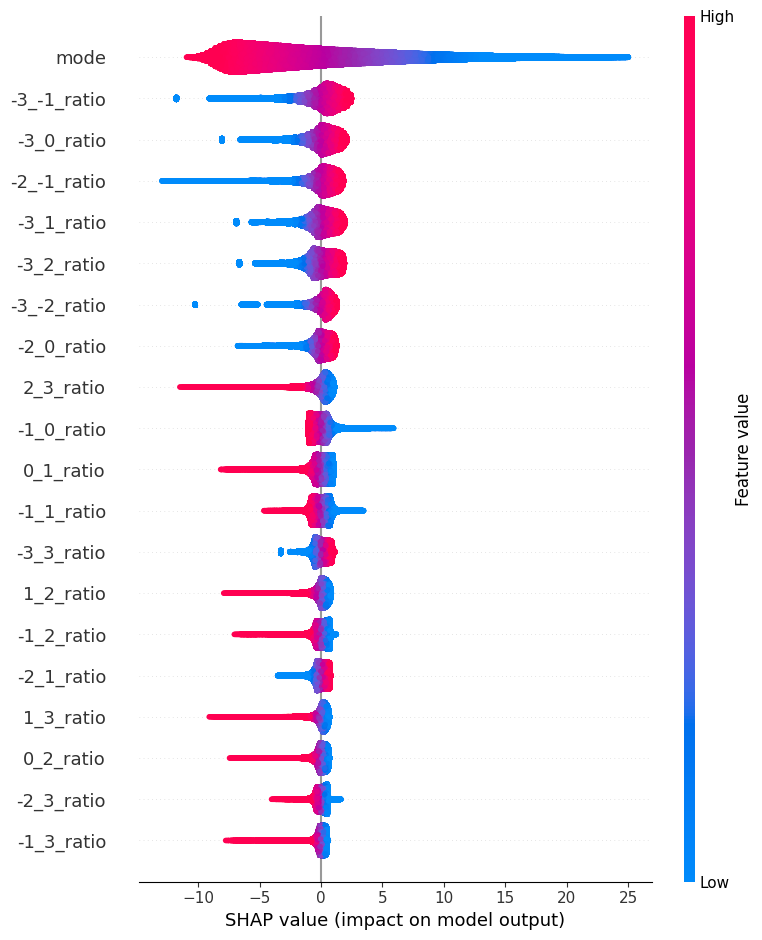

In [105]:
class_index = 7  # Replace with the desired class index
shap.summary_plot(shap_values[class_index], X_train_norm)

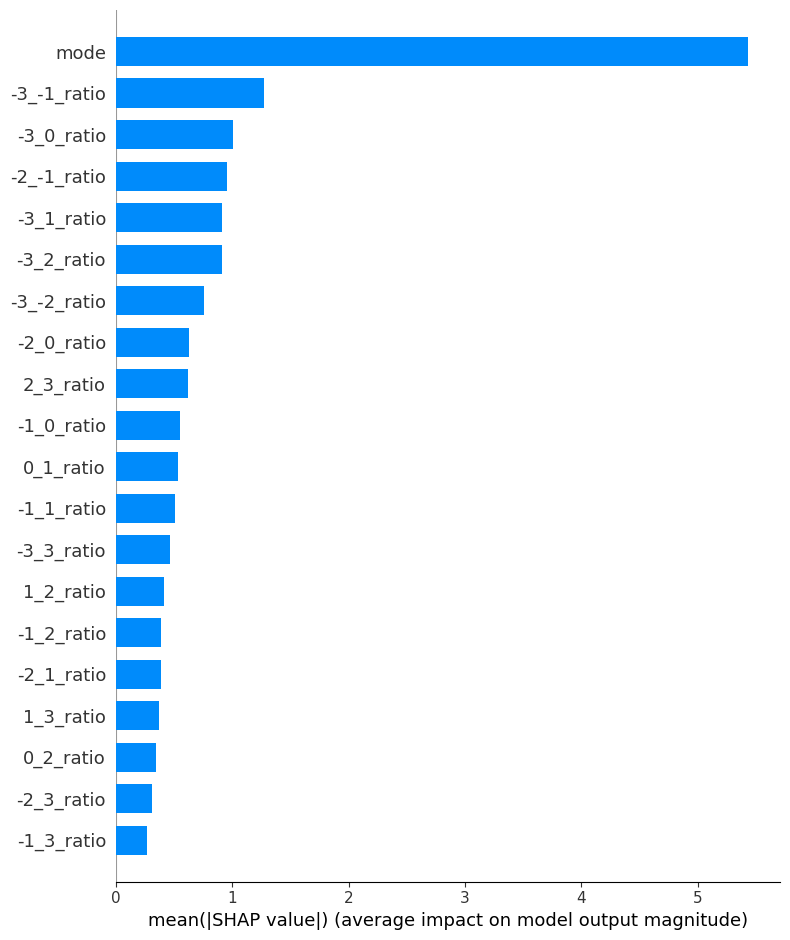

In [106]:
shap.summary_plot(shap_values[class_index], X_train_norm, plot_type="bar")

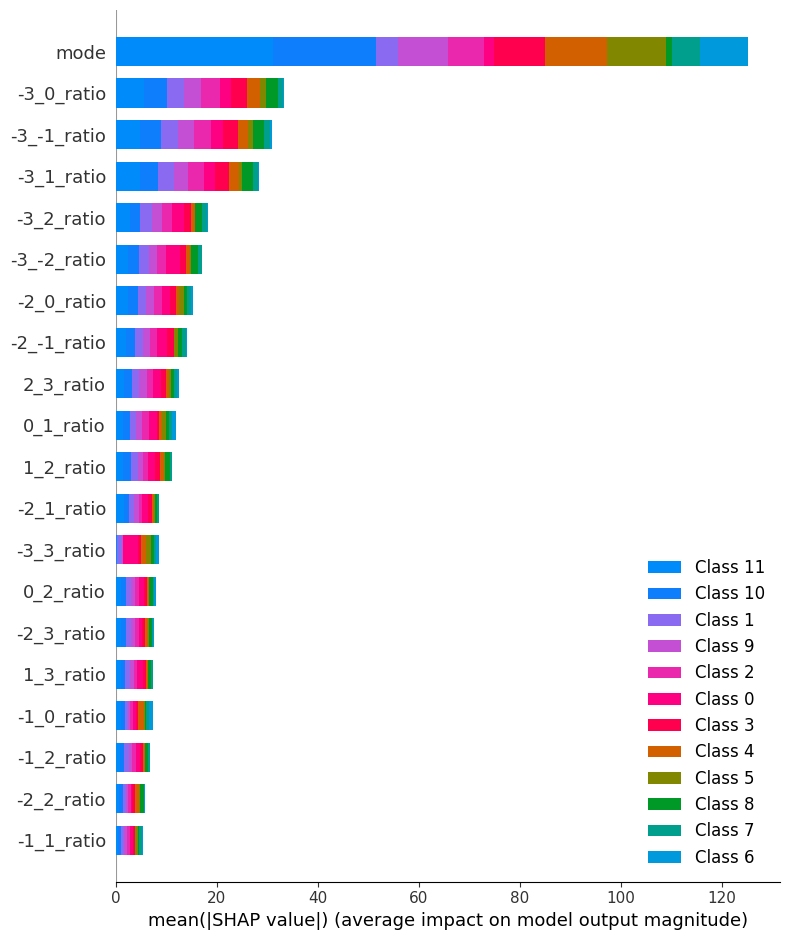

In [107]:
shap.summary_plot(shap_values, X_train_norm, plot_type="bar")

In [108]:
# Force plot
shap.initjs()
instance_index = 50000  # Replace with the desired instance index
shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][instance_index, :], X_train_norm.iloc[instance_index, :])


In [109]:
y_train.iloc[instance_index]

9

In [110]:
len(shap_values[0])
len(shap_values)
y.unique() # problem z niedoreprezentowaniem

array([ 9, 10, 13,  8, 11,  6,  3, 12,  7,  5,  2,  4])

In [111]:
model.classes_ # klasy - tj. szukane offsety


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [112]:
y_test.unique()

array([10, 11, 12,  9,  7,  5,  8,  3,  6, 13,  4,  2])

In [113]:
features.remove("mode")
features

['-3_-2_ratio',
 '-3_-1_ratio',
 '-3_0_ratio',
 '-3_1_ratio',
 '-3_2_ratio',
 '-3_3_ratio',
 '-2_-1_ratio',
 '-2_0_ratio',
 '-2_1_ratio',
 '-2_2_ratio',
 '-2_3_ratio',
 '-1_0_ratio',
 '-1_1_ratio',
 '-1_2_ratio',
 '-1_3_ratio',
 '0_1_ratio',
 '0_2_ratio',
 '0_3_ratio',
 '1_2_ratio',
 '1_3_ratio',
 '2_3_ratio']

In [114]:
X = df[features]
y = df["offset"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=200)
X_train_norm = (X_train - X_train.min())/(X_train.max() - X_train.min())
model.fit(X_train_norm, y_train)
X_test_norm = (X_test - X_test.min())/(X_test.max() - X_test.min())
y_pred = model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(accuracy,
      macro_precision, macro_recall, macro_f1,
      weighted_precision, weighted_recall, weighted_f1)

0.9979328708569827 0.9992805730331599 0.997297049660986 0.998264972752071 0.9979507166383759 0.9979328708569827 0.997920313278538


In [115]:
explainer = shap.LinearExplainer(model, X_train_norm)
shap_values = explainer.shap_values(X_train_norm)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


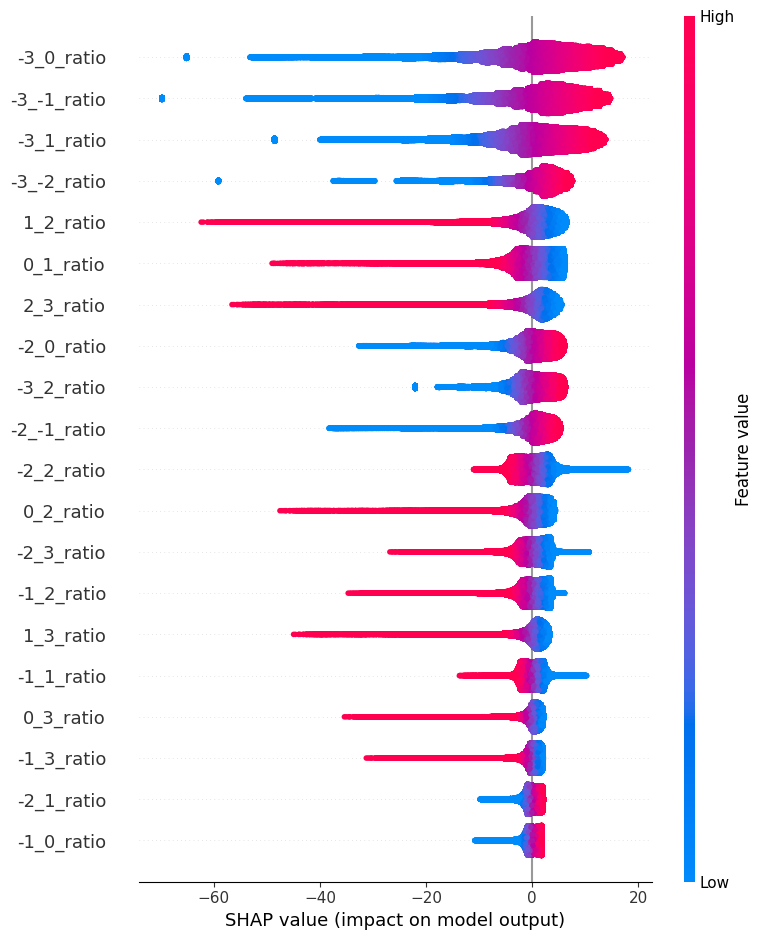

In [116]:
class_index = 10  # Replace with the desired class index
# shap.summary_plot(shap_values[class_index], X, plot_type="bar")
shap.summary_plot(shap_values[class_index], X_train_norm)

In [117]:
# Force plot
shap.initjs()
instance_index = 60000  # Replace with the desired instance index
shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][instance_index, :], X_train_norm.iloc[instance_index, :])


In [118]:
print(y_train.iloc[instance_index])

12


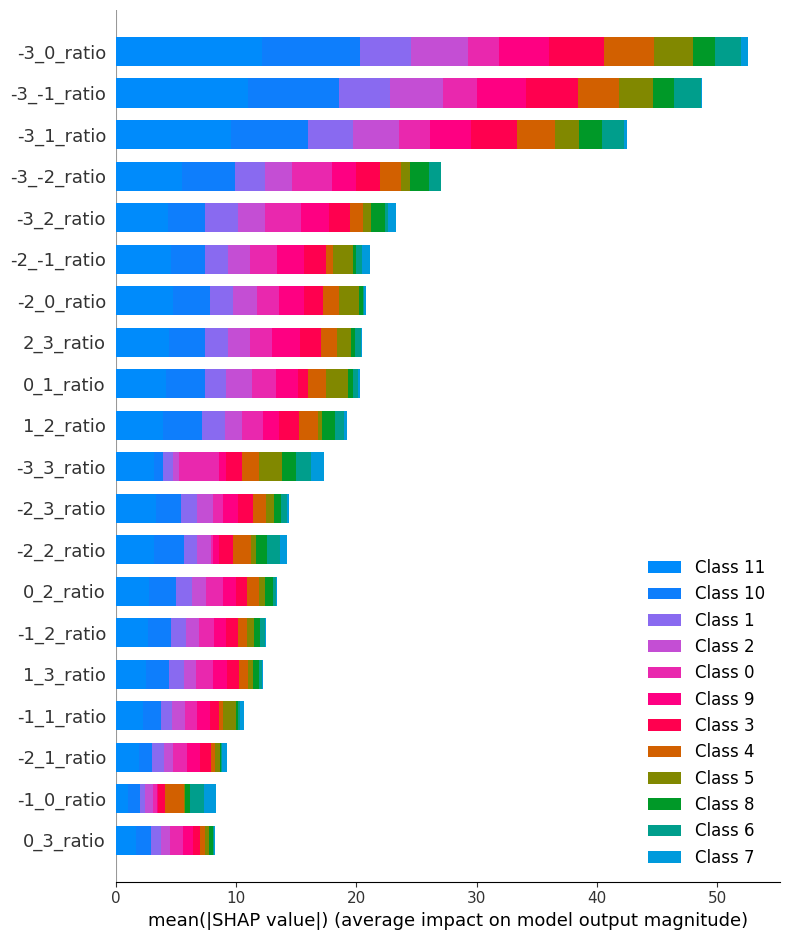

In [119]:
shap.summary_plot(shap_values, X, plot_type="bar")

## Podsumowanie i ewaluacja pracy:

Inne podejścia/możliwe rozszerzenia metody:

Przeprowadzenie analizy selekcji cech przed trenowaniem modelu. Można wyróżnić techniki univariate (gdzie cechy brane pod uwagę niezależnie) oraz multivariate (gdzie cechy brane w kontekście innych cech). W modelu zostały wykorzystane wszystkie cechy na raz, co mogło dość mocno skomplikować model.

Prawdziwe dane ze spektrometru są rzadko tak "czyste" jak w tej bazie. Dane wejściowe, czyli stosunki różnych wierzchołków, warto byłoby następnym razem zaszumić. Dobra byłaby np. do tego funkcja $Uniform \sim (1 - \omega, 1 + \omega) / Uniform \sim (1 - \omega, 1 + \omega)$, losująca dwie liczby z rozkładu jednostajnego z pewnego zakresu wokół 1, np. z $\omega = 0.1$ lub $0.25$.

Można by było również wykorzystać inny model, np. SVM, kNN lub sieć neuronową.